# Install relevant plugins 
pip install mysql-connector-python

pip install pandas sqlalchemy

pip install mysqlclient

In [1]:
#import libraries

import mysql.connector # connect to mysql
from mysql.connector import Error # error handling
import pandas as pd 
from sqlalchemy import create_engine #load dataframes into sql tables and vice versa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # linear algebra
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder,  OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score , mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

randomstate = 42
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200) #look at every column

In [2]:
# change this to your connection details
db_type = 'mysql'
username = 'root'
password = 'password'
host = 'localhost'
database_name = 'speedoc_hometest'

# Construct the connection string
connection_str = f'{db_type}://{username}:{password}@{host}/{database_name}'

# Create SQLAlchemy engine
engine = create_engine(connection_str)

# Read SQL tables into pandas DataFrames
stores_df = pd.read_sql_table('stores', con=engine)
train_df = pd.read_sql_table('train', con=engine)
features_df = pd.read_sql_table('features', con=engine)
test_df = pd.read_sql_table('test', con=engine)

# EDA

### Using .head() to look at the general structure of the dataframes, find cardinality/common keys to join on.

In [3]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096,8.106,0
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242,8.106,1
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289,8.106,0
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.320,8.106,0
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350,8.106,0


In [5]:
train_df.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.5,0
1,1,1,2010-02-12,46039.5,1
2,1,1,2010-02-19,41595.6,0
3,1,1,2010-02-26,19403.5,0
4,1,1,2010-03-05,21827.9,0
5,1,1,2010-03-12,21043.4,0
6,1,1,2010-03-19,22136.6,0
7,1,1,2010-03-26,26229.2,0
8,1,1,2010-04-02,57258.4,0
9,1,1,2010-04-09,42960.9,0


- data is recorded on a 7 day interval. 2010-02-12 is a friday, so all observations are recorded every friday.

In [6]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,0
1,1,1,2012-11-09,0
2,1,1,2012-11-16,0
3,1,1,2012-11-23,1
4,1,1,2012-11-30,0


### Merge features together with the other dataframes using an inner join on common keys. 

In [7]:
features_stores = pd.merge(stores_df, features_df, how='inner', on='Store') 

#add some extra date features for deeper analysis 
features_stores['Date'] = pd.to_datetime(features_stores['Date'])
features_stores['Year'] = features_stores['Date'].dt.year
features_stores['Month'] = features_stores['Date'].dt.month
features_stores['Week'] = features_stores['Date'].dt.isocalendar().week 
#only do weeks because the observations are recorded on a weekly basis, not on a daily basis.


In [8]:
train_df =  pd.merge(features_stores, train_df, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [9]:
test_df =  pd.merge(features_stores, test_df, how='inner', on=['Store', 'Date', 'IsHoliday']).sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

#### Look at the structure again.

In [10]:
pd.DataFrame({'Train Set': train_df.dtypes, 'Test Set': test_df.dtypes, 'Features_Stores Set': features_stores.dtypes})
    


,Train Set,Test Set,Features_Stores Set
CPI,float64,float64,float64
Date,datetime64[ns],datetime64[ns],datetime64[ns]
Dept,int64,int64,NaN
Fuel_Price,float64,float64,float64
IsHoliday,int64,int64,int64
MarkDown1,float64,float64,float64
MarkDown2,float64,float64,float64
MarkDown3,float64,float64,float64
MarkDown4,float64,float64,float64
MarkDown5,float64,float64,float64


IsHoliday was originally boolean but mapped to 1 and 0 after loading in the DF from SQL.

In [11]:
train_df.describe()

,Store,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.0,421570.000000,421570.000000
mean,22.200546,136727.915739,2011-06-18 08:30:31.963375104,60.090059,3.361027,7246.420358,3334.628750,1439.421960,3383.167971,4628.974728,171.201948,7.960289,0.070358,2010.968591,6.449510,25.826762,44.260317,15981.258064
min,1.000000,34875.000000,2010-02-05 00:00:00,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,0.000000,2010.000000,1.000000,1.0,1.000000,-4988.940000
25%,11.000000,93638.000000,2010-10-08 00:00:00,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.023000,6.891000,0.000000,2010.000000,4.000000,14.0,18.000000,2079.650000
50%,22.000000,140167.000000,2011-06-17 00:00:00,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.319000,7.866000,0.000000,2011.000000,6.000000,26.0,37.000000,7612.030000
75%,33.000000,202505.000000,2012-02-24 00:00:00,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.417000,8.572000,0.000000,2012.000000,9.000000,38.0,74.000000,20205.875000
max,45.000000,219622.000000,2012-10-26 00:00:00,100.140000,4.468000,88646.800000,104520.000000,141631.000000,67474.900000,108519.000000,227.233000,14.313000,1.000000,2012.000000,12.000000,52.0,99.000000,693099.000000
std,12.785297,60980.583328,NaN,18.447931,0.458515,8291.221504,9475.360037,9623.084862,6292.383491,5962.884046,39.159273,1.863296,0.255750,0.796876,3.243217,14.151887,30.492054,22711.183207


In [12]:
pd.DataFrame({
    'Train Set (% missing values)': train_df.isna().sum() / train_df.shape[0] * 100,
    'Test Set (% missing values)': test_df.isna().sum() / test_df.shape[0] * 100,
    'Features_Stores Set (% missing values)': features_stores.isna().sum() / features_stores.shape[0] * 100
}).T

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Month,Size,Store,Temperature,Type,Unemployment,Week,Weekly_Sales,Year
Train Set (% missing values),0.000000,0.0,0.0,0.0,0.0,64.257181,73.611025,67.480845,67.984676,64.079038,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
Test Set (% missing values),33.165890,0.0,0.0,0.0,0.0,0.129493,24.879198,8.542203,11.200723,0.000000,0.0,0.0,0.0,0.0,0.0,33.165890,0.0,NaN,0.0
Features_Stores Set (% missing values),7.142857,0.0,NaN,0.0,0.0,50.769231,64.334554,55.885226,57.704518,50.549451,0.0,0.0,0.0,0.0,0.0,7.142857,0.0,NaN,0.0


- the 5 markdowns have a high % of in training set and features_stores set.
- kaggle mentioned that these were anonymized data of promotional markdowns that walmart was running so lets see if it has any correlation to the sales.
- there are missing values in the test set and training set for CPI and Unemployment and they have the same exact %. 

# Pearsons Correlation Matrix

High correlation = 0.7 to 1.0

Med correlation = 0.4 to 0.7

Low correlation = < 0.4

No correlation = 0 


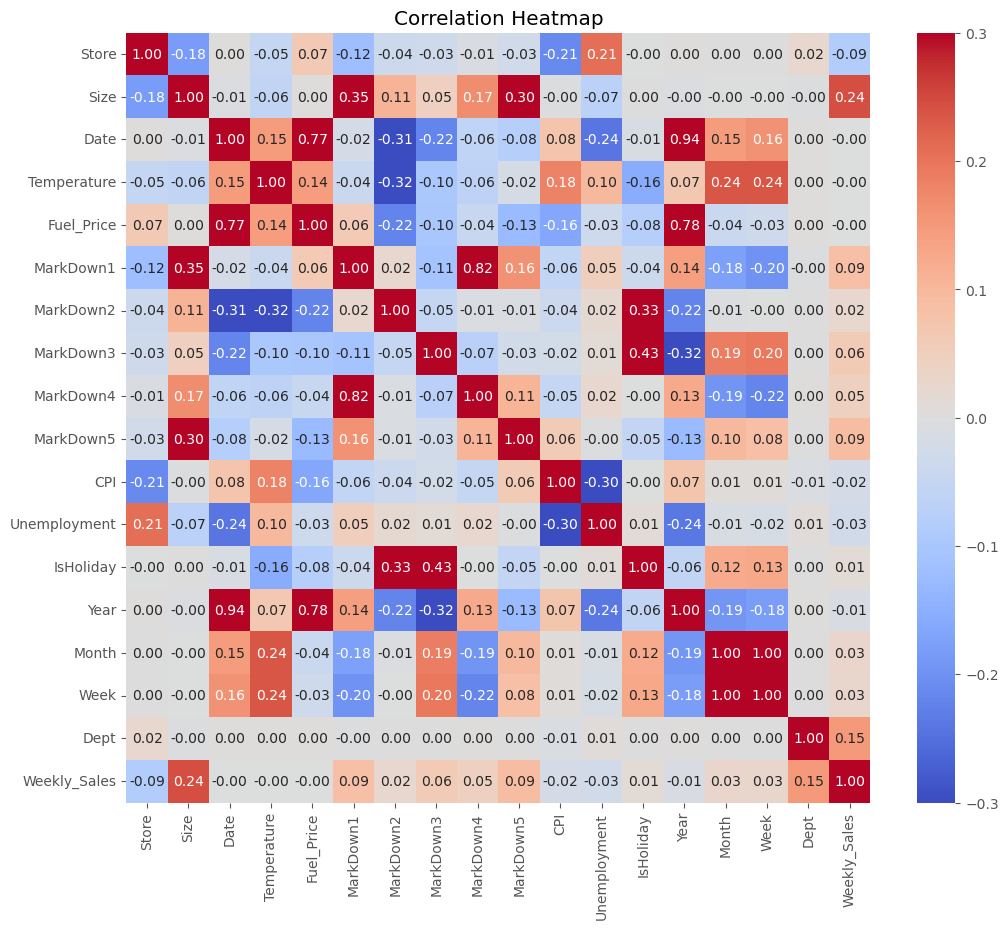

In [13]:
#run a correlation heatmap

train_numerical = train_df.select_dtypes(exclude=['object'])


corr = train_numerical.corr()

plt.figure(figsize=(12, 10))



sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',  vmax=0.3,  vmin=-0.3)


plt.yticks(rotation=0)


plt.title('Correlation Heatmap')

plt.show()

- while the markdowns are indicative of promotional markdowns (slight correlation to isHoliday), they are not highly correlated with sales. However let's keep them because since we can investigate the effect of these markdowns on sales according to the holidays. 

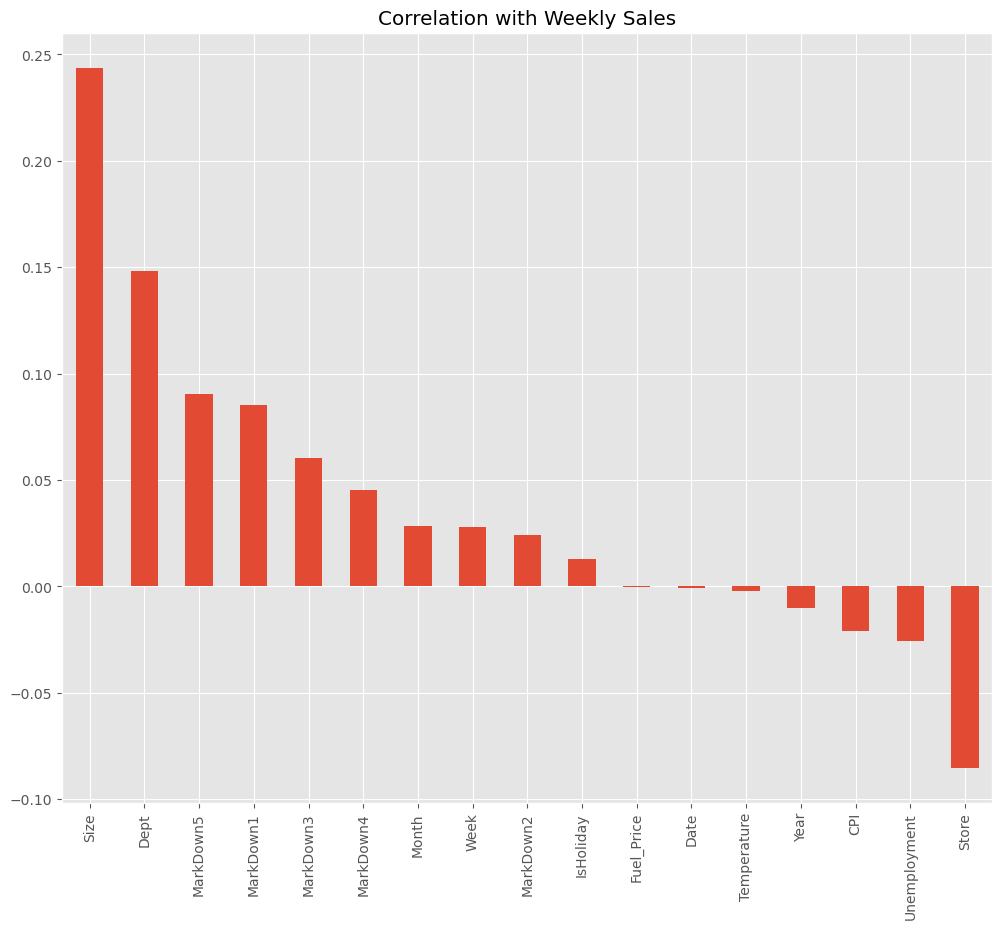

In [14]:
#create a bar chart according to the correlation values, omit weekly sales
corr = train_numerical.corr()
corr = corr['Weekly_Sales'].sort_values(ascending=False)
corr = corr.drop('Weekly_Sales', axis=0)
plt.figure(figsize=(12, 10))
ax = corr.plot(kind='bar')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Correlation with Weekly Sales')
plt.show()


- size and department have a positive slight correlation to sales (0.24 and 0.15 respectively) while cpi, store and unemployment has a negative correlation ( -0.16, -0.13 and -0.11 respectively).

# Exploring sales across different variables and factors

# Holidays 

lets investigate the significance of sales vs holidays.

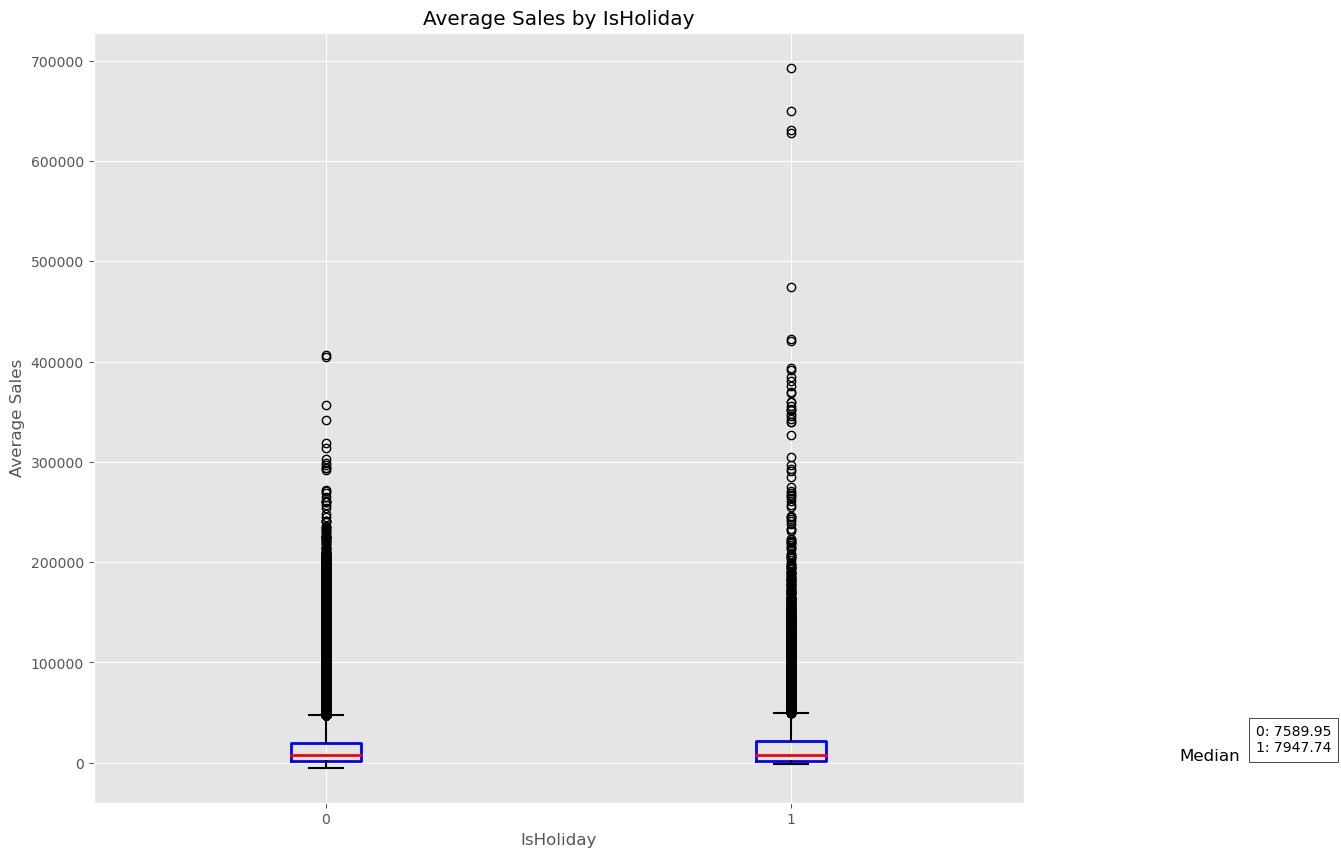

In [15]:
# Calculate average sales for each IsHoliday
isholiday_sale = train_df.groupby('IsHoliday')['Weekly_Sales'].mean()

# Create a box plot
plt.figure(figsize=(12, 10))
box = plt.boxplot([train_df[train_df['IsHoliday'] == i]['Weekly_Sales'] for i in isholiday_sale.index],
                  labels=isholiday_sale.index,
                  boxprops=dict(color='blue', linewidth=2),
                  whiskerprops=dict(color='black', linewidth=1.5),
                  capprops=dict(color='black', linewidth=1.5),
                  medianprops=dict(color='red', linewidth=2))

plt.xlabel('IsHoliday')
plt.ylabel('Average Sales')
plt.title('Average Sales by IsHoliday')

# Annotate medians with their values in a box beside the plot
medians = [np.median(train_df[train_df['IsHoliday'] == i]['Weekly_Sales']) for i in isholiday_sale.index]
median_text = '\n'.join(f"{i}: {median:.2f}" for i, median in zip(isholiday_sale.index, medians))

plt.text(len(isholiday_sale.index) + 1, np.max(medians), median_text, ha='left', va='bottom', fontsize=10,
         bbox=dict(boxstyle='square,pad=0.5', fc='white', ec='black'))


median_label = 'Median'
plt.text(len(isholiday_sale.index) + 0.9 , np.max(medians), median_label, ha='center', va='center_baseline', fontsize=12)

plt.show()

- generally, holidays have higher average sales on median.

lets take note of holidays in the dataset.


Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13



lets find out which weeks in the holidays are recorded

In [16]:
# Given holiday dates
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

super_bowl_weeks = train_df[train_df['Date'].isin(super_bowl_dates)]['Week'].unique()
labor_day_weeks = train_df[train_df['Date'].isin(labor_day_dates)]['Week'].unique()
thanksgiving_weeks = train_df[train_df['Date'].isin(thanksgiving_dates)]['Week'].unique()
christmas_weeks = train_df[train_df['Date'].isin(christmas_dates)]['Week'].unique()

print("Super Bowl Weeks:", super_bowl_weeks)
print("Labor Day Weeks:", labor_day_weeks)
print("Thanksgiving Weeks:", thanksgiving_weeks)
print("Christmas Weeks:", christmas_weeks)

Super Bowl Weeks: <IntegerArray>
[6]
Length: 1, dtype: UInt32
Labor Day Weeks: <IntegerArray>
[36]
Length: 1, dtype: UInt32
Thanksgiving Weeks: <IntegerArray>
[47]
Length: 1, dtype: UInt32
Christmas Weeks: <IntegerArray>
[52]
Length: 1, dtype: UInt32


## Total sales across the week of each year

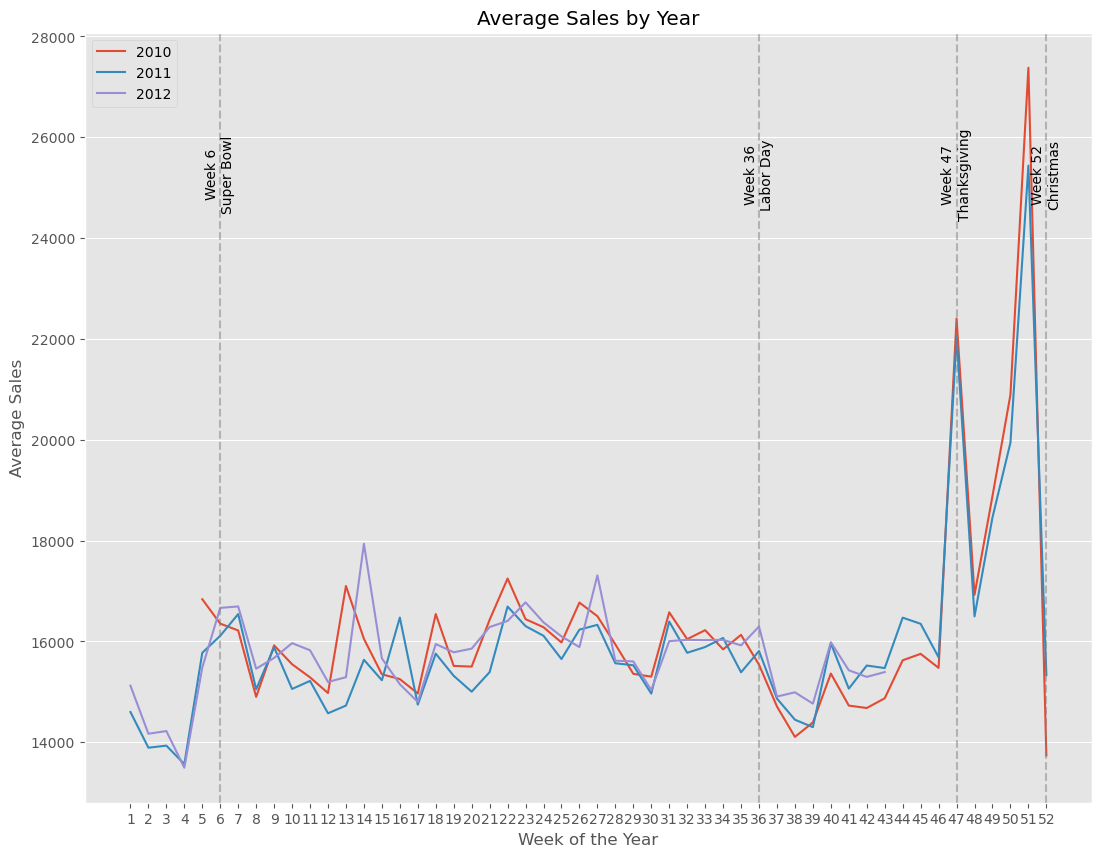

In [17]:
# Find the average sales for each year (2010, 2011, 2012)
weekly_sales_2010 = train_df[train_df['Year'] == 2010].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2011 = train_df[train_df['Year'] == 2011].groupby('Week')['Weekly_Sales'].mean()
weekly_sales_2012 = train_df[train_df['Year'] == 2012].groupby('Week')['Weekly_Sales'].mean()

# Plot a line chart
plt.figure(figsize=(13, 10))
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values, label='2010')
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values, label='2011')
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values, label='2012')
plt.xlabel('Week of the Year')
plt.ylabel('Average Sales')
plt.title('Average Sales by Year')
plt.legend()

# Show every x tick
plt.xticks(np.arange(1, 53, 1))  # Set ticks from 1 to 52
plt.grid(axis='x')  # Add gridlines along the x-axis for better readability

# Annotate according to holiday weeks in 2010, 2011, and 2012
holidays_2010_2012 = [(week, 'Super Bowl') for week in super_bowl_weeks] + [(week, 'Labor Day') for week in labor_day_weeks] + [(week, 'Thanksgiving') for week in thanksgiving_weeks] + [(week, 'Christmas') for week in christmas_weeks]

for holiday_week, holiday_name in holidays_2010_2012:
    plt.axvline(x=holiday_week, color='gray', linestyle='--', alpha=0.5)  # Vertical lines for holidays
    plt.text(holiday_week, plt.ylim()[1] * 0.9, f"Week {holiday_week}\n{holiday_name}", rotation=90, ha='center', va='center')

plt.show()

### Let's look at the graph spikes and see if there is any missing holidays in any of the weeks.
- Week 13 and 14 there is a spike, looking at the holiday dates online - this week is from 28th March to 4th April. Holidays during this time is Good Friday and Easter which are not recorded in the dataset.
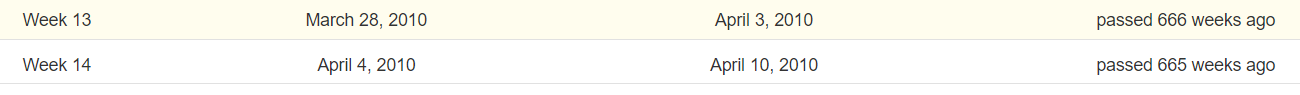
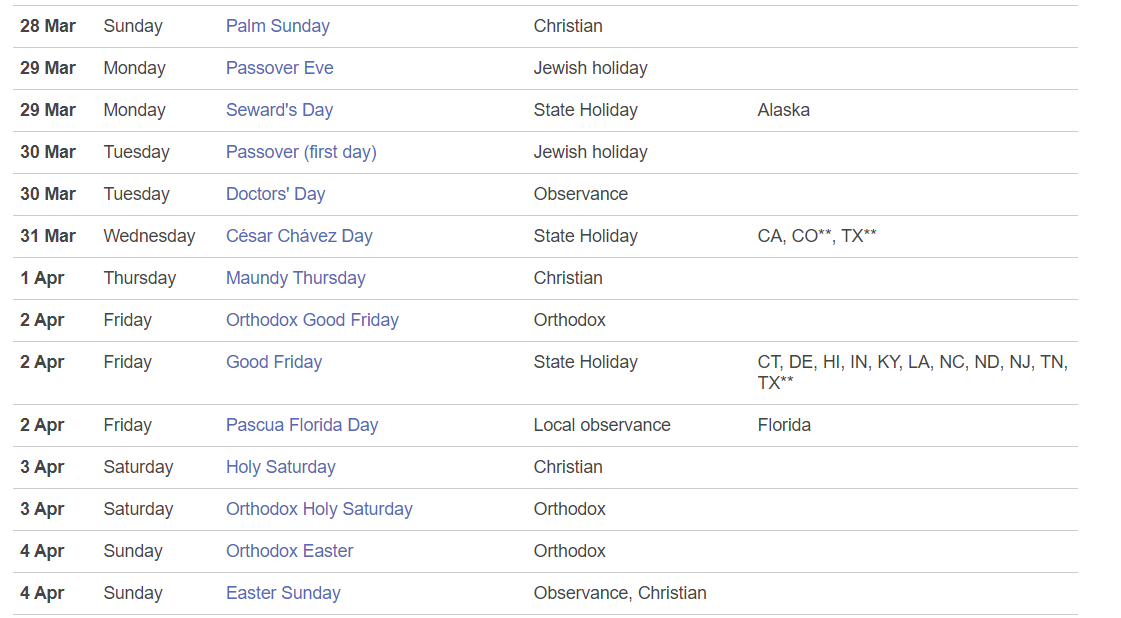

According to CNBC, easter is one of the biggest spending holidays so lets just take note of the Easter Dates in 2010, 2011, 2012.

Easter : 4-Apr-2010, 24-Apr-2011, 8-Apr-2012, 31-Mar-2013
Which are weeks 13, 16, 14, 13 


The second potential holiday that is missing is independence day which is on the 4th july that falls on the 27th week.
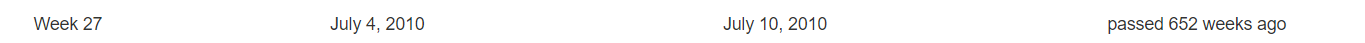
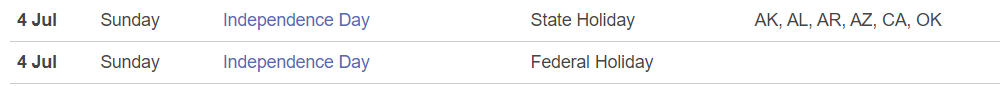
Independence day : 4-Jul-2010, 4-Jul-2011, 4-Jul-2012, 4 jul 2013

Lets change the holidays from false to true. 

In [18]:
# Weeks corresponding to Easter for each year
easter_weeks_train = {
    2010: 13,
    2011: 16,
    2012: 14,
}

# Weeks corresponding to Independence day for each year
independence_weeks_train = {
    2010: 27,
    2011: 27,
    2012: 27,
}

# Set 'IsHoliday' to True for the specified weeks in each year
for year, week in easter_weeks_train.items():
    train_df.loc[(train_df['Year'] == year) & (train_df['Week'] == week), 'IsHoliday'] = True
    
for year, week in independence_weeks_train.items():
    train_df.loc[(train_df['Year'] == year) & (train_df['Week'] == week), 'IsHoliday'] = True

In [19]:
# Weeks corresponding to Easter for each year
easter_weeks_test = {
    2012: 14,
    2013: 13 
}

# Weeks corresponding to Easter for each year
independence_weeks_test = {
    2012: 27,
    2013: 27
}

# Set 'IsHoliday' to True for the specified weeks in each year
for year, week in easter_weeks_test.items():
    test_df.loc[(test_df['Year'] == year) & (train_df['Week'] == week), 'IsHoliday'] = True
    
for year, week in independence_weeks_test.items():
    test_df.loc[(test_df['Year'] == year) & (train_df['Week'] == week), 'IsHoliday'] = True

## Find total sales across different variables of the store (dept, type e.g.)

# Store sales 

C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\3304064855.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', len(sorted_stores))
C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\3304064855.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Total Sales')
C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\3304064855.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}M'.format(y/1e6) for y in cbar.get_ticks()])  # Format color bar ticks in millions


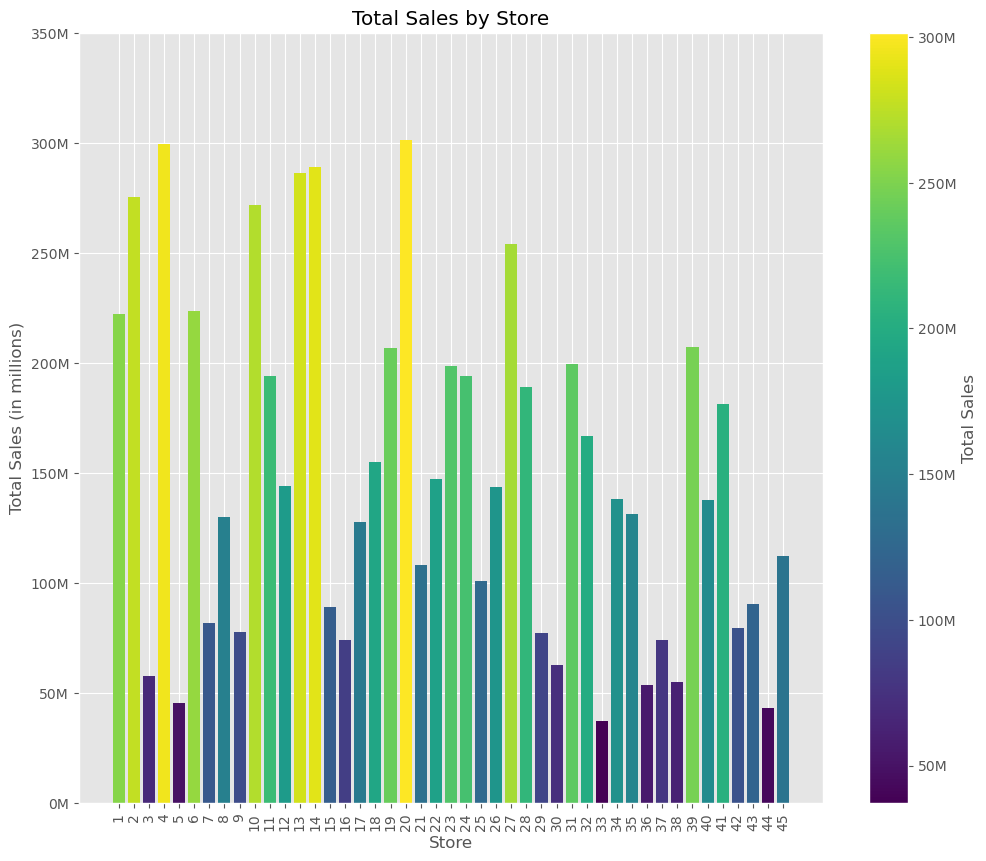

In [20]:
# Calculate total sales for each store
store_sales = train_df.groupby('Store')['Weekly_Sales'].sum()

# Sort stores based on total sales in ascending order
sorted_stores = store_sales.sort_values()

# Create a colormap based on the number of stores
colormap = plt.cm.get_cmap('viridis', len(sorted_stores))

# Plot bar graph with colors according to increasing total sales
plt.figure(figsize=(12, 10))
bars = plt.bar(sorted_stores.index, sorted_stores, color=[colormap(i) for i in range(len(sorted_stores))])

#show every x tick
plt.xticks(sorted_stores.index, sorted_stores.index, rotation=90)

plt.xlabel('Store')
plt.ylabel('Total Sales (in millions)')
plt.title('Total Sales by Store')

# Add y-axis labels in millions
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
plt.yticks(ticks=plt.gca().get_yticks(), labels=['{:.0f}M'.format(x / 1e6) for x in plt.gca().get_yticks()])

# Add color bar legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=sorted_stores.min(), vmax=sorted_stores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, label='Total Sales')
cbar.ax.set_yticklabels(['{:.0f}M'.format(y/1e6) for y in cbar.get_ticks()])  # Format color bar ticks in millions

plt.show()

- sales do vary across stores 

## Dept sales

C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\907549484.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', len(sorted_depts))
C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\907549484.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, label='Average Sales')
C:\Users\Admin\AppData\Local\Temp\ipykernel_11828\907549484.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['{:.0f}'.format(y) for y in cbar.get_ticks()])  # Format color bar ticks as integers


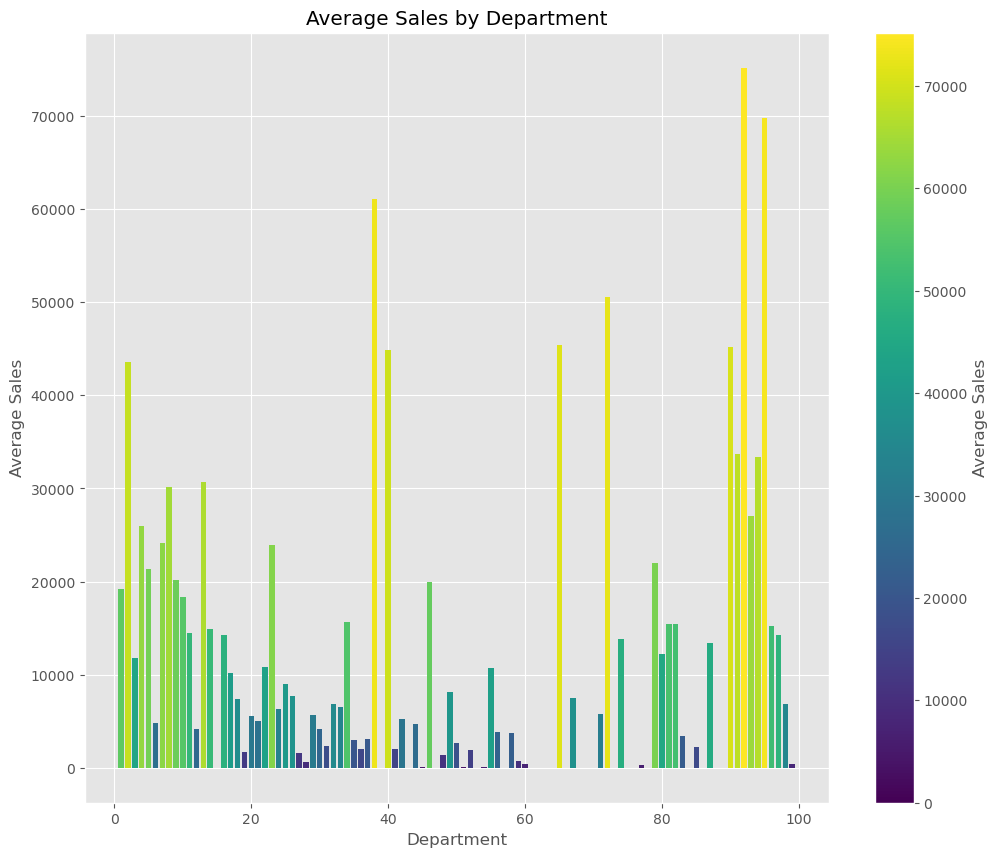

In [21]:
# Calculate average sales for each department
dept_sales = train_df.groupby('Dept')['Weekly_Sales'].mean()

# Sort departments based on average sales in ascending order
sorted_depts = dept_sales.sort_values()

# Create a colormap based on the number of departments
colormap = plt.cm.get_cmap('viridis', len(sorted_depts))

# Plot bar chart with colors according to increasing average sales
plt.figure(figsize=(12, 10))
bars = plt.bar(sorted_depts.index, sorted_depts, color=[colormap(i) for i in range(len(sorted_depts))])

plt.xlabel('Department')
plt.ylabel('Average Sales')
plt.title('Average Sales by Department')

# Add color bar legend
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=sorted_depts.min(), vmax=sorted_depts.max()))
sm.set_array([])
cbar = plt.colorbar(sm, label='Average Sales')
cbar.ax.set_yticklabels(['{:.0f}'.format(y) for y in cbar.get_ticks()])  # Format color bar ticks as integers

# Show plot
plt.show()


departments heavily vary across 

## Size & Type sales 

Text(0.5, 1.0, 'Sales by Size')

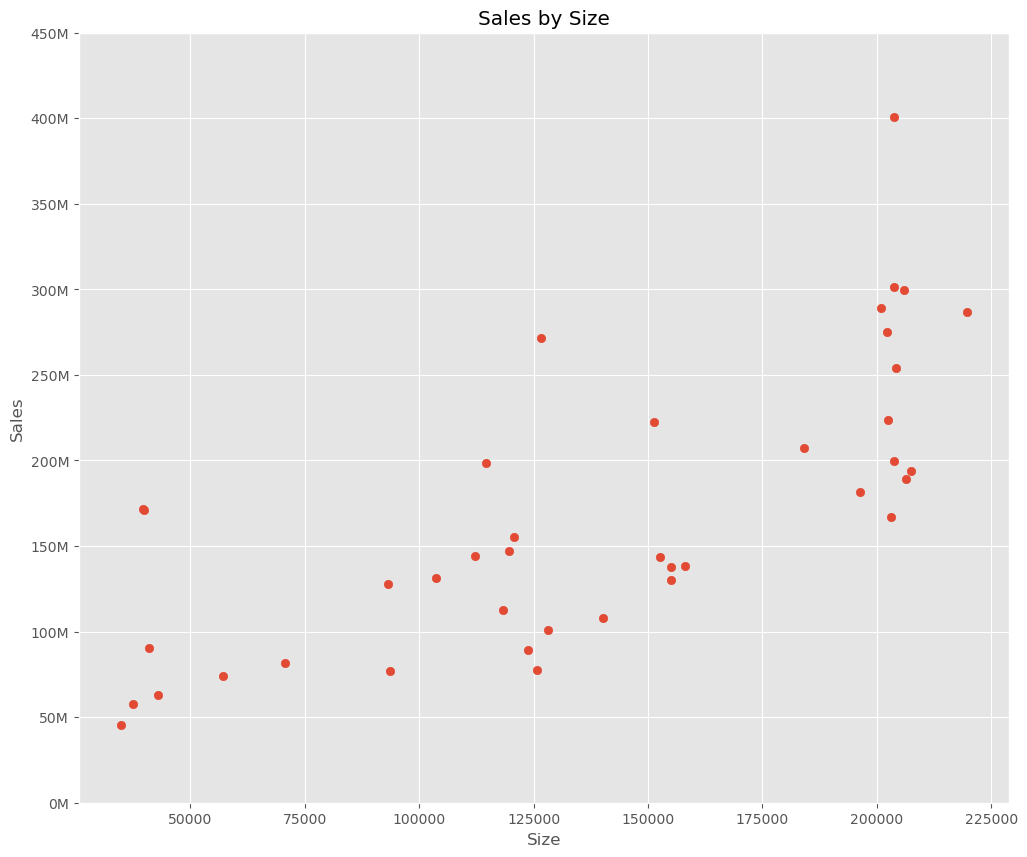

In [22]:
#create a scatter plot for size and total average weekly sales

sizes_sale = train_df.groupby('Size')['Weekly_Sales'].sum()

plt.figure(figsize=(12, 10))
plt.scatter(sizes_sale.index, sizes_sale.values)

# Add y-axis labels in millions
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
plt.yticks(ticks=plt.gca().get_yticks(), labels=['{:.0f}M'.format(x / 1e6) for x in plt.gca().get_yticks()])

plt.xlabel('Size')
plt.ylabel('Sales')
plt.title('Sales by Size')


generally bigger size means more average weekly sales 

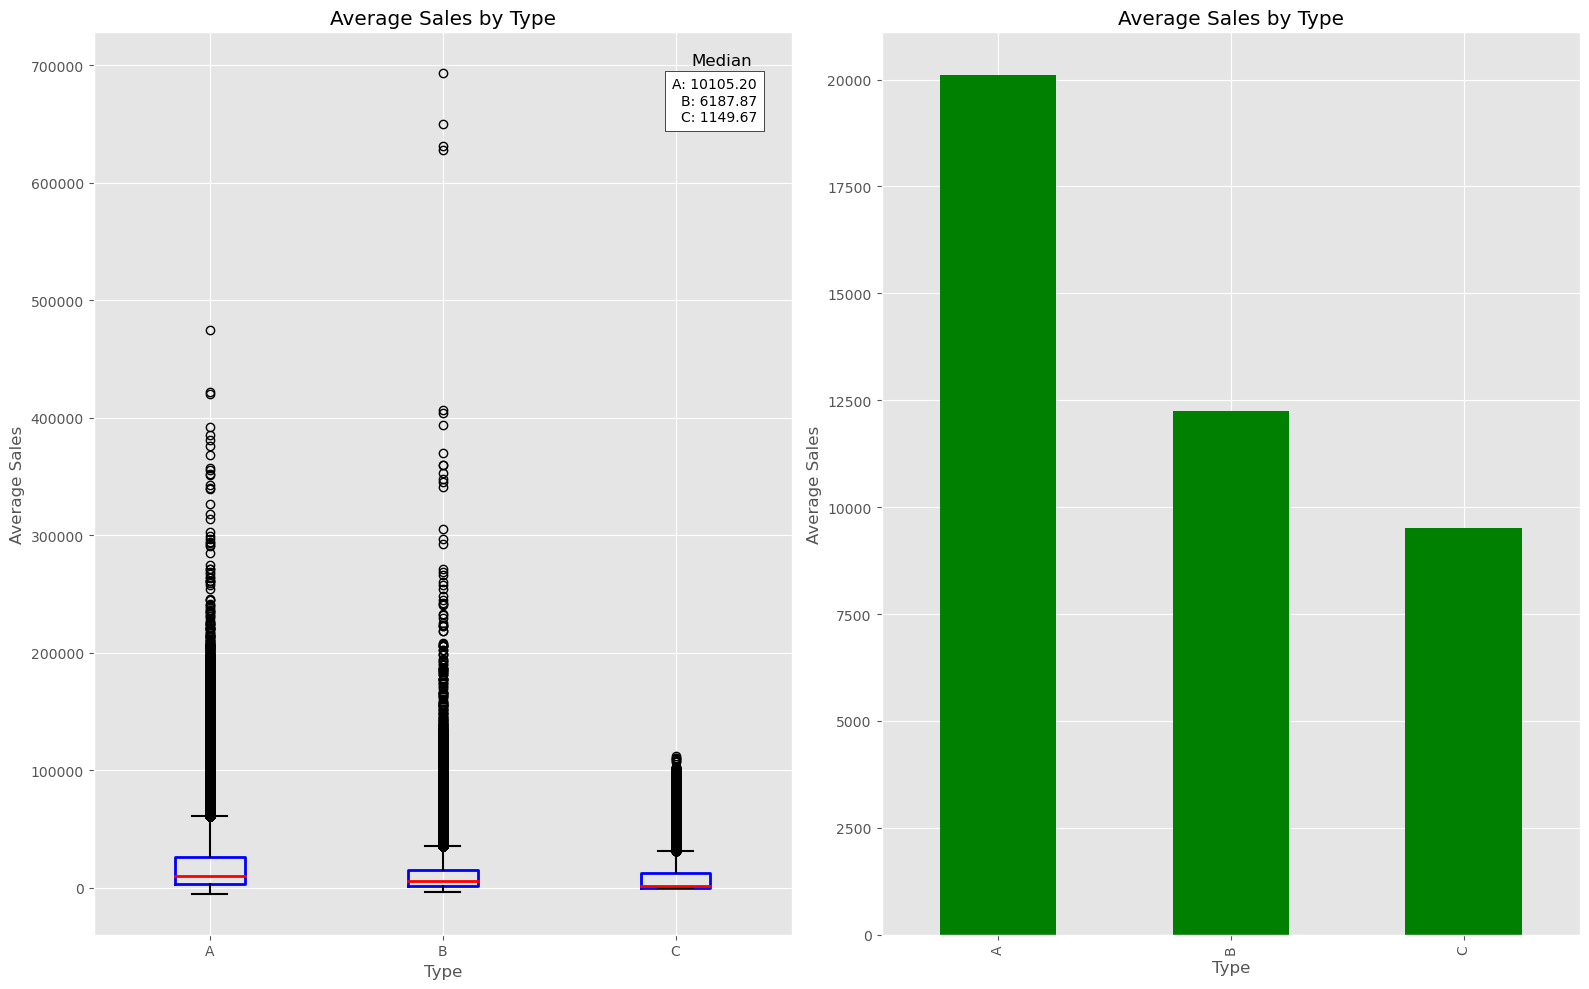

In [23]:
# Calculate average sales for each type
type_sales = train_df.groupby('Type')['Weekly_Sales'].mean()

# Calculate median for each type
medians = [np.median(train_df[train_df['Type'] == i]['Weekly_Sales']) for i in type_sales.index]

fig, (ax_box, ax_bar) = plt.subplots(1, 2, figsize=(16, 10))

# Box plot
ax_box.boxplot([train_df[train_df['Type'] == t]['Weekly_Sales'] for t in type_sales.index], labels=type_sales.index,
                boxprops=dict(color='blue', linewidth=2),
                whiskerprops=dict(color='black', linewidth=1.5),
                capprops=dict(color='black', linewidth=1.5),
                medianprops=dict(color='red', linewidth=2))

ax_box.set_xlabel('Type')
ax_box.set_ylabel('Average Sales')
ax_box.set_title('Average Sales by Type')

# Annotations for medians on the box plot
median_text = '\n'.join(f"{i}: {median:.2f}" for i, median in zip(type_sales.index, medians))
ax_box.text(0.95, 0.95, median_text, ha='right', va='top', transform=ax_box.transAxes, fontsize=10,
             bbox=dict(boxstyle='square,pad=0.5', fc='white', ec='black'))

# Add label 'Median' on top of the box plot
ax_box.text(0.90, 0.96, 'Median', ha='center', va='bottom', transform=ax_box.transAxes, fontsize=12)

# Bar chart
type_sales.plot(kind='bar', ax=ax_bar, color='green')
ax_bar.set_xlabel('Type')
ax_bar.set_ylabel('Average Sales')
ax_bar.set_title('Average Sales by Type')

plt.tight_layout()
plt.show()


Can see that Type A stores are the highest earning ones followed by B and C (in terms of median)

<Figure size 1200x1000 with 0 Axes>

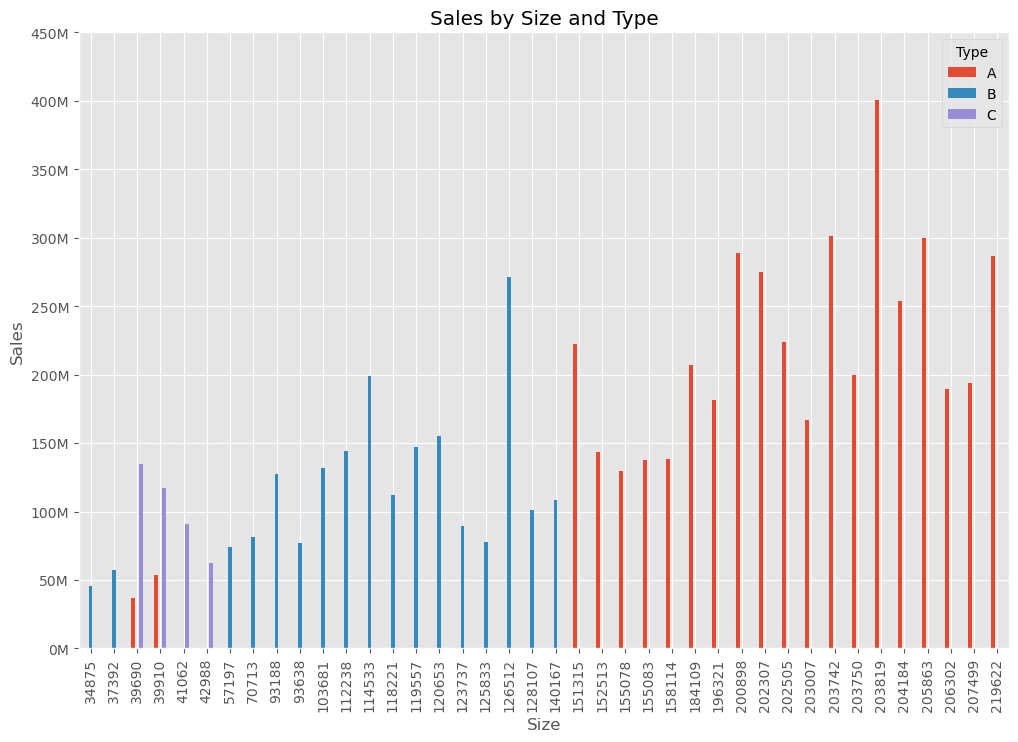

In [24]:
sizes_type_sale = train_df.groupby(['Size', 'Type'])['Weekly_Sales'].sum().unstack()

plt.figure(figsize=(12, 10))
sizes_type_sale.plot(kind='bar', figsize=(12, 8))

# Add y-axis labels in millions
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
plt.yticks(ticks=plt.gca().get_yticks(), labels=['{:.0f}M'.format(x / 1e6) for x in plt.gca().get_yticks()])

plt.xlabel('Size')
plt.ylabel('Sales')
plt.title('Sales by Size and Type')
plt.legend(title='Type')

plt.show()


## Other variables, temp, fuel_price, CPI, Unemployment

I think temperature is in Fahrenheit because looking at the summary statistics, there's no way that temperature can be at 100 degrees.

In [25]:
# Convert Fahrenheit to Celsius and round to 2 decimal places
train_df['Temperature'] = round((train_df['Temperature'] - 32) * 5 / 9, 2)
train_df.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Week,Dept,Weekly_Sales
0,1,A,151315,2010-02-05,5.73,2.572,NaN,NaN,NaN,NaN,NaN,211.096,8.106,0,2010,2,5,1,24924.5
1,1,A,151315,2010-02-12,3.62,2.548,NaN,NaN,NaN,NaN,NaN,211.242,8.106,1,2010,2,6,1,46039.5
2,1,A,151315,2010-02-19,4.41,2.514,NaN,NaN,NaN,NaN,NaN,211.289,8.106,0,2010,2,7,1,41595.6
3,1,A,151315,2010-02-26,8.13,2.561,NaN,NaN,NaN,NaN,NaN,211.320,8.106,0,2010,2,8,1,19403.5
4,1,A,151315,2010-03-05,8.06,2.625,NaN,NaN,NaN,NaN,NaN,211.350,8.106,0,2010,3,9,1,21827.9


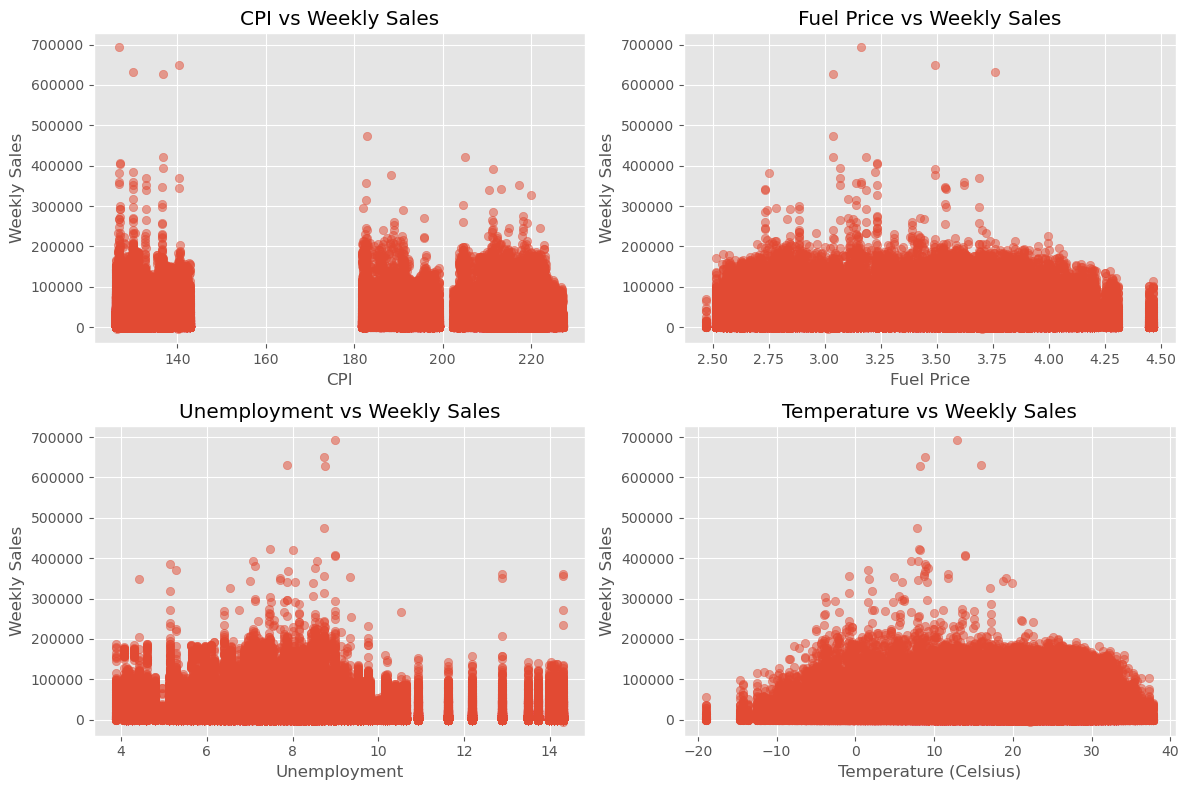

In [26]:
plt.figure(figsize=(12, 8))

# Scatter plot for CPI vs. Weekly Sales
plt.subplot(221)
plt.scatter(train_df['CPI'], train_df['Weekly_Sales'], alpha=0.5)
plt.xlabel('CPI')
plt.ylabel('Weekly Sales')
plt.title('CPI vs Weekly Sales')

# Scatter plot for Fuel Price vs. Weekly Sales
plt.subplot(222)
plt.scatter(train_df['Fuel_Price'], train_df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Fuel Price')
plt.ylabel('Weekly Sales')
plt.title('Fuel Price vs Weekly Sales')

# Scatter plot for Unemployment vs. Weekly Sales
plt.subplot(223)
plt.scatter(train_df['Unemployment'], train_df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Unemployment')
plt.ylabel('Weekly Sales')
plt.title('Unemployment vs Weekly Sales')

# Scatter plot for Temperature vs. Weekly Sales
plt.subplot(224)
plt.scatter(train_df['Temperature'], train_df['Weekly_Sales'], alpha=0.5)
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Weekly Sales')
plt.title('Temperature vs Weekly Sales')

plt.tight_layout()
plt.show()


these variables don't actually show any correlation or relationship with sales so I will actually drop them.b

In [27]:
#drop
train_df.drop(['CPI', 'Unemployment', 'Fuel_Price', 'Temperature'], axis=1, inplace=True)
test_df.drop(['CPI', 'Unemployment', 'Fuel_Price', 'Temperature'], axis=1, inplace=True)

In [28]:
easter_weeks = [13,16,14]

independence_weeks = [27]


# Markdown investigation

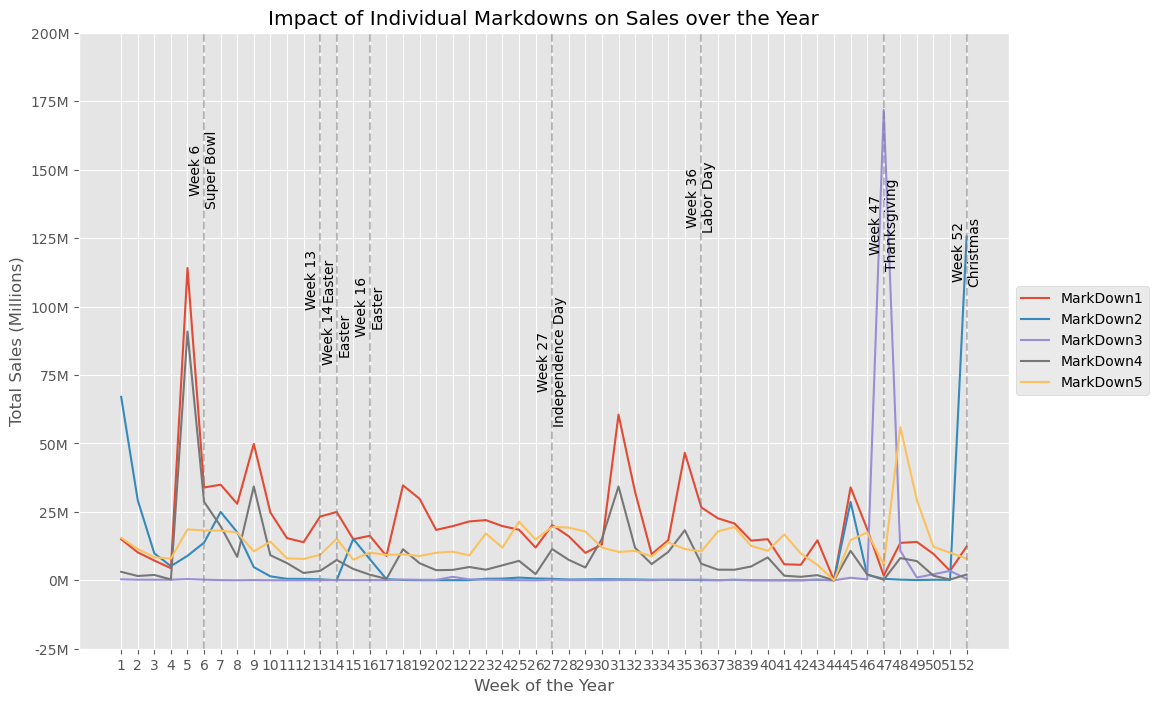

In [29]:
# Find the total sales for each Markdown (Markdown1 to Markdown5) over the weeks
markdowns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
plt.figure(figsize=(12, 8))

for md in markdowns:
    # Group by week and calculate the total sales for each Markdown
    total_sales = train_df.groupby('Week')[md].sum()
    
    # Plot line chart for each Markdown
    plt.plot(total_sales.index, total_sales.values, label=md)

# Add y-axis labels in millions
plt.ticklabel_format(style='plain', axis='y')  # Avoid scientific notation
plt.yticks(ticks=plt.gca().get_yticks(), labels=['{:.0f}M'.format(x / 1e6) for x in plt.gca().get_yticks()])

# Annotate according to holiday weeks in 2010, 2011, and 2012
holidays_2010_2012 = [(week, 'Super Bowl') for week in super_bowl_weeks] + [(week, 'Labor Day') for week in labor_day_weeks] + [(week, 'Thanksgiving') for week in thanksgiving_weeks] + [(week, 'Christmas') for week in christmas_weeks] + [(week, 'Easter') for week in easter_weeks] + [(week, 'Independence Day') for week in independence_weeks]

#Get y-axis limits
y_min, y_max = plt.ylim()

# Annotate according to holiday weeks in 2010, 2011, and 2012
for i, (holiday_week, holiday_name) in enumerate(holidays_2010_2012):
    y_offset = i * 0.05  # Adjust the vertical spacing between annotations
    y_pos = y_max * (0.75 - y_offset)  # Calculate adjusted y-coordinate for annotation
    plt.axvline(x=holiday_week, color='gray', linestyle='--', alpha=0.5)  # Vertical lines for holidays
    plt.text(holiday_week, y_pos, f"Week {holiday_week}\n{holiday_name}", rotation=90, ha='center', va='center')


    
plt.xlabel('Week of the Year')
plt.ylabel('Total Sales (Millions)')
plt.title('Impact of Individual Markdowns on Sales over the Year')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xticks(np.arange(1, 53, 1))  # Show every x tick
plt.show()


- No markdown promotional sales for easter or independence day
- Markdown 1 and 4 could be a sale for Super bowl as seen in spikes of sales from 1 or 2 weeks before (could be preparation for the superbowl
- Markdown 1 and 4 could also be a sale for labor day as seen in spikes of sales from 1 or 2 weeks before
- Markdown 2 could be a sale for christmas and new years as it only spikes heavily during those times
- Markdown 3 is definitely a sale for thanks giving as it peaks during thanksgiving
- No idea what markdown 5 could be, possibly christmas pre-sale?.

Its seen that markdown 1 has the most amount of irregular spikes throughout the year, so markdown 1 could represent other miscellaneous promotions.

One key thing we can derive that this markdowns boost sales for certain times during the year. Markdown 3 is the most significant in terms of boosting the highest sales performance for thanksgiving.

# Data pre-processing

In [30]:
train_df.isna().sum()

Store                0
Type                 0
Size                 0
Date                 0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
IsHoliday            0
Year                 0
Month                0
Week                 0
Dept                 0
Weekly_Sales         0
dtype: int64

In [31]:
test_df.isna().sum()
    


Store            0
Type             0
Size             0
Date             0
MarkDown1      149
MarkDown2    28627
MarkDown3     9829
MarkDown4    12888
MarkDown5        0
IsHoliday        0
Year             0
Month            0
Week             0
Dept             0
dtype: int64

lets replace NA markdown values with 0

In [32]:
#fill missing values from Markdowns with 0
train_df.fillna(0, inplace=True)

In [33]:
train_df.isna().sum()

Store           0
Type            0
Size            0
Date            0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
IsHoliday       0
Year            0
Month           0
Week            0
Dept            0
Weekly_Sales    0
dtype: int64

In [34]:
test_df.isna().sum()
    


Store            0
Type             0
Size             0
Date             0
MarkDown1      149
MarkDown2    28627
MarkDown3     9829
MarkDown4    12888
MarkDown5        0
IsHoliday        0
Year             0
Month            0
Week             0
Dept             0
dtype: int64

lets encode the type in ordinal ranking with A as the most important and C as the least important

In [35]:
# Define the ordinal mapping
ordinal_mapping = {'A': 3, 'B': 2, 'C': 1}

train_df['Type'] = train_df['Type'].replace(ordinal_mapping)

# Check the updated DataFrame with the ordinal encoding
print(train_df[['Type']].head())


   Type
0     3
1     3
2     3
3     3
4     3


In [36]:
test_df['Type'] = test_df['Type'].replace(ordinal_mapping)

# Check the updated DataFrame with the ordinal encoding
print(test_df[['Type']].head())

   Type
0     3
1     3
2     3
3     3
4     3


# baseline model for PFI 

In [37]:
#setup df to contain all scores across various "engineering" or PDCA cycles, for easy reading
results = pd.DataFrame(['cv_mae_test','cv_std_test','cv_mae_train','cv_std_train','best'])
results

,0
0,cv_mae_test
1,cv_std_test
2,cv_mae_train
3,cv_std_train
4,best


In [38]:
# Extracting features and target variable
X = train_df.drop(['Weekly_Sales', 'Date'], axis=1)
y = train_df['Weekly_Sales']

# Holdout Strategy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)

# Convert all column names to strings in X_train and X_test
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]


## training baseline model

I use DTR because my laptop cannot handle RFR :(

In [39]:
# Create a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=randomstate)
# Create a pipeline
pipeline = Pipeline(steps=[
    ('regressor', dtr)
])
# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth':  range(5, 30, 5)  # Varying depths to scan
}
# Initialize GridSearchCV
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=randomstate)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error')

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Using cross_val_score with the best estimator
scores_test =  cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
scores_train =  cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate and print mean and standard deviation for test and train sets
mean_score_test = np. mean(scores_test)
std_score_test = np.std(scores_test)
mean_score_train = np. mean(scores_train)
std_score_train = np.std(scores_train)

results_in = pd.DataFrame([mean_score_test,std_score_test,mean_score_train,std_score_train,grid_search.best_params_],columns=['ordinal baseline'])
results = pd.concat([results,results_in],axis=1)
results

Best parameters: {'regressor__max_depth': 25}
Best score: -1788.6008516671911


,0,ordinal baseline
0,cv_mae_test,-2363.385024
1,cv_std_test,31.298866
2,cv_mae_train,-1788.600852
3,cv_std_train,11.959028
4,best,{'regressor__max_depth': 25}


In [40]:
#permutation feature importance
from sklearn.inspection import permutation_importance

#compute permutation importance
perm_importance =  permutation_importance(grid_search.best_estimator_, X_test, y_test, n_repeats=10,
                                          random_state=randomstate, n_jobs=-1)

#extract feature names
feature_names = X_train.columns

#Create a dataframe to display feature importance
df_feature_importance = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns=['importance'])

#sort the dataframe by importance
df_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

#display the dataframe and number them
df_feature_importance['rank'] = range(1, len(df_feature_importance) + 1)
print( df_feature_importance)

           importance  rank
Dept         1.772533     1
Size         0.679896     2
Week         0.214726     3
Store        0.205360     4
Type         0.064323     5
Month        0.054295     6
IsHoliday    0.006318     7
Year         0.005585     8
MarkDown4    0.004348     9
MarkDown1    0.002341    10
MarkDown3    0.002274    11
MarkDown5    0.001847    12
MarkDown2    0.001358    13


# Feature engineering

### lets add some features and see if they improve our model performance/or become important features in the PFI list.

## Plan 
- add some features such as days until the holidays e.g. 1 week to christmas etc
- rationale, customers usually purchase before the day of the holiday itself to pre-prepare.
- business idea : create promotions in x amt of weeks before for a pre-holiday sale to increase sales.

## Do

In [41]:
df_in = train_df.copy()
df_out = df_in.copy()

In [42]:
from datetime import datetime
# Given holiday dates
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

# Convert holiday dates to datetime objects
super_bowl_dates = [datetime.strptime(date, '%Y-%m-%d') for date in super_bowl_dates]
labor_day_dates = [datetime.strptime(date, '%Y-%m-%d') for date in labor_day_dates]
thanksgiving_dates = [datetime.strptime(date, '%Y-%m-%d') for date in thanksgiving_dates]
christmas_dates = [datetime.strptime(date, '%Y-%m-%d') for date in christmas_dates]

def days_before_holiday(date_column, holiday_dates):
    days_until = []
    for date in date_column:
        days = [(holiday_date - date).days for holiday_date in holiday_dates]
        closest_holiday = min(days, key=abs)  # Find the closest holiday
        days_until.append(abs(closest_holiday))  # Absolute value of days
    return days_until


# Calculate days before each holiday for each week in train_df
df_out['Days_to_Super_Bowl'] = days_before_holiday(train_df['Date'], super_bowl_dates)
df_out['Days_to_Labor_Day'] = days_before_holiday(train_df['Date'], labor_day_dates)
df_out['Days_to_Thanksgiving'] = days_before_holiday(train_df['Date'], thanksgiving_dates)
df_out['Days_to_Christmas'] = days_before_holiday(train_df['Date'], christmas_dates)

# Display the updated DataFrame with new features
print(df_out)


        Store  Type    Size       Date  MarkDown1  MarkDown2  MarkDown3  \
0           1     3  151315 2010-02-05       0.00       0.00       0.00   
1           1     3  151315 2010-02-12       0.00       0.00       0.00   
2           1     3  151315 2010-02-19       0.00       0.00       0.00   
3           1     3  151315 2010-02-26       0.00       0.00       0.00   
4           1     3  151315 2010-03-05       0.00       0.00       0.00   
...       ...   ...     ...        ...        ...        ...        ...   
421565     45     2  118221 2012-09-28    4556.61      20.64       1.50   
421566     45     2  118221 2012-10-05    5046.74       0.00      18.82   
421567     45     2  118221 2012-10-12    1956.28       0.00       7.89   
421568     45     2  118221 2012-10-19    2004.02       0.00       3.18   
421569     45     2  118221 2012-10-26    4018.91      58.08     100.00   

        MarkDown4  MarkDown5 IsHoliday  Year  Month  Week  Dept  Weekly_Sales  \
0            0.00 

# Check if it improves performance

In [43]:
# Extracting features and target variable
X = df_out.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_out['Weekly_Sales']

# Holdout Strategy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)

# Convert all column names to strings in X_train and X_test
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]

In [44]:
# Create a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=randomstate)
# Create a pipeline
pipeline = Pipeline(steps=[
    ('regressor', dtr)
])
# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth':  range(5, 30, 5)  # Varying depths to scan
}
# Initialize GridSearchCV
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=randomstate)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error')

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Using cross_val_score with the best estimator
scores_test =  cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
scores_train =  cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate and print mean and standard deviation for test and train sets
mean_score_test = np. mean(scores_test)
std_score_test = np.std(scores_test)
mean_score_train = np. mean(scores_train)
std_score_train = np.std(scores_train)

results_in = pd.DataFrame([mean_score_test,std_score_test,mean_score_train,std_score_train,grid_search.best_params_],columns=['FE cycle 1'])
results = pd.concat([results,results_in],axis=1)
results

Best parameters: {'regressor__max_depth': 20}
Best score: -1788.1080289356173


,0,ordinal baseline,FE cycle 1
0,cv_mae_test,-2363.385024,-2361.182517
1,cv_std_test,31.298866,38.596967
2,cv_mae_train,-1788.600852,-1788.108029
3,cv_std_train,11.959028,9.6004
4,best,{'regressor__max_depth': 25},{'regressor__max_depth': 20}


well in terms of model performance it did not improve so much

In [45]:
#compute permutation importance
perm_importance =  permutation_importance(grid_search.best_estimator_, X_test, y_test, n_repeats=10,
                                          random_state=randomstate, n_jobs=-1)

#extract feature names
feature_names = X_train.columns

#Create a dataframe to display feature importance
df_feature_importance = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns=['importance'])

#sort the dataframe by importance
df_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

#display the dataframe and number them
df_feature_importance['rank'] = range(1, len(df_feature_importance) + 1)
print( df_feature_importance)

                      importance  rank
Dept                    1.772045     1
Size                    0.665309     2
Store                   0.196926     3
Week                    0.072751     4
Days_to_Thanksgiving    0.050641     5
Type                    0.045076     6
Days_to_Super_Bowl      0.016943     7
Days_to_Labor_Day       0.014319     8
Days_to_Christmas       0.010302     9
Year                    0.004250    10
MarkDown4               0.003438    11
Month                   0.003048    12
IsHoliday               0.002641    13
MarkDown5               0.001903    14
MarkDown1               0.001099    15
MarkDown3               0.001084    16
MarkDown2               0.000700    17


but it is important in terms of feature importance (top 10) so I will keep it.

In [46]:
df_in = df_out.copy()

In [47]:
df_out = df_in.copy()

Lets try the same for independence day and easter, in terms of weeks 

In [48]:
# Given weeks for Easter and Independence Day
easter_weeks = [13, 16, 14]
independence_weeks = [27]

# Define functions to calculate weeks before Easter and Independence Day
def weeks_before_holiday(week_column, holiday_weeks):
    weeks_until = []
    for week in week_column:
        weeks = [abs(week - holiday_week) for holiday_week in holiday_weeks]
        closest_holiday = min(weeks)
        weeks_until.append(closest_holiday)  # Append the absolute value
    return weeks_until

# Calculate weeks before Easter and Independence Day for each recorded week in train_df
df_out['Weeks_to_Easter'] = weeks_before_holiday(train_df['Week'], easter_weeks)
df_out['Weeks_to_Independence_Day'] = weeks_before_holiday(train_df['Week'], independence_weeks)

# Display the updated DataFrame with new features
print(df_out)


        Store  Type    Size       Date  MarkDown1  MarkDown2  MarkDown3  \
0           1     3  151315 2010-02-05       0.00       0.00       0.00   
1           1     3  151315 2010-02-12       0.00       0.00       0.00   
2           1     3  151315 2010-02-19       0.00       0.00       0.00   
3           1     3  151315 2010-02-26       0.00       0.00       0.00   
4           1     3  151315 2010-03-05       0.00       0.00       0.00   
...       ...   ...     ...        ...        ...        ...        ...   
421565     45     2  118221 2012-09-28    4556.61      20.64       1.50   
421566     45     2  118221 2012-10-05    5046.74       0.00      18.82   
421567     45     2  118221 2012-10-12    1956.28       0.00       7.89   
421568     45     2  118221 2012-10-19    2004.02       0.00       3.18   
421569     45     2  118221 2012-10-26    4018.91      58.08     100.00   

        MarkDown4  MarkDown5 IsHoliday  Year  Month  Week  Dept  Weekly_Sales  \
0            0.00 

In [49]:
# Extracting features and target variable
X = df_out.drop(['Weekly_Sales', 'Date'], axis=1)
y = df_out['Weekly_Sales']

# Holdout Strategy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)

# Convert all column names to strings in X_train and X_test
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]

# Create a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=randomstate)
# Create a pipeline
pipeline = Pipeline(steps=[
    ('regressor', dtr)
])
# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth':  range(5, 30, 5)  # Varying depths to scan
}
# Initialize GridSearchCV
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=randomstate)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error')

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Using cross_val_score with the best estimator
scores_test =  cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
scores_train =  cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate and print mean and standard deviation for test and train sets
mean_score_test = np. mean(scores_test)
std_score_test = np.std(scores_test)
mean_score_train = np. mean(scores_train)
std_score_train = np.std(scores_train)

results_in = pd.DataFrame([mean_score_test,std_score_test,mean_score_train,std_score_train,grid_search.best_params_],columns=['FE cycle 2'])
results = pd.concat([results,results_in],axis=1)
results

Best parameters: {'regressor__max_depth': 20}
Best score: -1787.2009597895697


,0,ordinal baseline,FE cycle 1,FE cycle 2
0,cv_mae_test,-2363.385024,-2361.182517,-2367.995436
1,cv_std_test,31.298866,38.596967,29.442419
2,cv_mae_train,-1788.600852,-1788.108029,-1787.20096
3,cv_std_train,11.959028,9.6004,13.727969
4,best,{'regressor__max_depth': 25},{'regressor__max_depth': 20},{'regressor__max_depth': 20}


In [50]:
#compute permutation importance
perm_importance =  permutation_importance(grid_search.best_estimator_, X_test, y_test, n_repeats=10,
                                          random_state=randomstate, n_jobs=-1)

#extract feature names
feature_names = X_train.columns

#Create a dataframe to display feature importance
df_feature_importance = pd.DataFrame(perm_importance.importances_mean, index=feature_names, columns=['importance'])

#sort the dataframe by importance
df_feature_importance.sort_values(by='importance', ascending=False, inplace=True)

#display the dataframe and number them
df_feature_importance['rank'] = range(1, len(df_feature_importance) + 1)
print( df_feature_importance)

                           importance  rank
Dept                         1.771068     1
Size                         0.648771     2
Store                        0.198216     3
Weeks_to_Easter              0.042276     4
Days_to_Thanksgiving         0.040958     5
Type                         0.037273     6
Weeks_to_Independence_Day    0.022762     7
Week                         0.016213     8
Days_to_Super_Bowl           0.015963     9
Days_to_Christmas            0.007926    10
Days_to_Labor_Day            0.005981    11
IsHoliday                    0.004320    12
Year                         0.003608    13
MarkDown4                    0.003404    14
Month                        0.001761    15
MarkDown1                    0.001682    16
MarkDown5                    0.001388    17
MarkDown2                    0.001306    18
MarkDown3                    0.000890    19


In [51]:
df_in = df_out.copy()
df_out = df_in.copy()

model performance did not change significantly but it is part of the top 12 features.

# Final model

In [52]:
df_in.drop(['Date','MarkDown4','MarkDown5','MarkDown1','MarkDown2','MarkDown3','Year'], axis=1, inplace=True)

In [53]:
# Given holiday dates
super_bowl_dates = ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08']
labor_day_dates = ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06']
thanksgiving_dates = ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29']
christmas_dates = ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']

# Convert holiday dates to datetime objects
super_bowl_dates = [datetime.strptime(date, '%Y-%m-%d') for date in super_bowl_dates]
labor_day_dates = [datetime.strptime(date, '%Y-%m-%d') for date in labor_day_dates]
thanksgiving_dates = [datetime.strptime(date, '%Y-%m-%d') for date in thanksgiving_dates]
christmas_dates = [datetime.strptime(date, '%Y-%m-%d') for date in christmas_dates]

def days_before_holiday(date_column, holiday_dates):
    days_until = []
    for date in date_column:
        days = [(holiday_date - date).days for holiday_date in holiday_dates]
        closest_holiday = min(days, key=abs)  # Find the closest holiday
        days_until.append(abs(closest_holiday))  # Absolute value of days
    return days_until


# Calculate days before each holiday for each week in train_df
test_df['Days_to_Super_Bowl'] = days_before_holiday(test_df['Date'], super_bowl_dates)
test_df['Days_to_Labor_Day'] = days_before_holiday(test_df['Date'], labor_day_dates)
test_df['Days_to_Thanksgiving'] = days_before_holiday(test_df['Date'], thanksgiving_dates)
test_df['Days_to_Christmas'] = days_before_holiday(test_df['Date'], christmas_dates)

# Display the updated DataFrame with new features
print(test_df.head())


   Store  Type    Size       Date  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0      1     3  151315 2012-11-02    6766.44    5147.70      50.82    3639.90   
1      1     3  151315 2012-11-09   11421.30    3370.89      40.28    4646.79   
2      1     3  151315 2012-11-16    9696.28     292.10     103.78    1133.15   
3      1     3  151315 2012-11-23     883.59       4.17   74910.30     209.91   
4      1     3  151315 2012-11-30    2460.03        NaN    3838.35     150.57   

   MarkDown5 IsHoliday  Year  Month  Week  Dept  Days_to_Super_Bowl  \
0    2737.42         0  2012     11    44     1                  98   
1    6154.16         0  2012     11    45     1                  91   
2    6612.69         0  2012     11    46     1                  84   
3     303.32         1  2012     11    47     1                  77   
4    6966.34         0  2012     11    48     1                  70   

   Days_to_Labor_Day  Days_to_Thanksgiving  Days_to_Christmas  
0                 56  

In [54]:
# Given weeks for Easter and Independence Day
easter_weeks = [13, 16, 14]
independence_weeks = [27]

# Define functions to calculate weeks before Easter and Independence Day
def weeks_before_holiday(week_column, holiday_weeks):
    weeks_until = []
    for week in week_column:
        weeks = [abs(week - holiday_week) for holiday_week in holiday_weeks]
        closest_holiday = min(weeks)
        weeks_until.append(closest_holiday)  # Append the absolute value
    return weeks_until

# Calculate weeks before Easter and Independence Day for each recorded week in train_df
test_df['Weeks_to_Easter'] = weeks_before_holiday(test_df['Week'], easter_weeks)
test_df['Weeks_to_Independence_Day'] = weeks_before_holiday(test_df['Week'], independence_weeks)

# Display the updated DataFrame with new features
print(df_out)


        Store  Type    Size       Date  MarkDown1  MarkDown2  MarkDown3  \
0           1     3  151315 2010-02-05       0.00       0.00       0.00   
1           1     3  151315 2010-02-12       0.00       0.00       0.00   
2           1     3  151315 2010-02-19       0.00       0.00       0.00   
3           1     3  151315 2010-02-26       0.00       0.00       0.00   
4           1     3  151315 2010-03-05       0.00       0.00       0.00   
...       ...   ...     ...        ...        ...        ...        ...   
421565     45     2  118221 2012-09-28    4556.61      20.64       1.50   
421566     45     2  118221 2012-10-05    5046.74       0.00      18.82   
421567     45     2  118221 2012-10-12    1956.28       0.00       7.89   
421568     45     2  118221 2012-10-19    2004.02       0.00       3.18   
421569     45     2  118221 2012-10-26    4018.91      58.08     100.00   

        MarkDown4  MarkDown5 IsHoliday  Year  Month  Week  Dept  Weekly_Sales  \
0            0.00 

In [55]:
test_df.drop(['Date','MarkDown4','MarkDown5','MarkDown1','MarkDown2','MarkDown3','Year'], axis=1, inplace=True)

In [56]:
# Extracting features and target variable
X = df_in.drop(['Weekly_Sales'], axis=1)
y = df_in['Weekly_Sales']

# Holdout Strategy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=randomstate)

# Convert all column names to strings in X_train and X_test
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_test.columns]

# Create a Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=randomstate)
# Create a pipeline
pipeline = Pipeline(steps=[
    ('regressor', dtr)
])
# Define the parameter grid for GridSearchCV
param_grid = {
    'regressor__max_depth':  range(5, 30, 5)  # Varying depths to scan
}
# Initialize GridSearchCV
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=randomstate)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_absolute_error')

# Fit the model on training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Using cross_val_score with the best estimator
scores_test =  cross_val_score(grid_search.best_estimator_, X_test, y_test, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
scores_train =  cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

# Calculate and print mean and standard deviation for test and train sets
mean_score_test = np. mean(scores_test)
std_score_test = np.std(scores_test)
mean_score_train = np. mean(scores_train)
std_score_train = np.std(scores_train)

results_in = pd.DataFrame([mean_score_test,std_score_test,mean_score_train,std_score_train,grid_search.best_params_],columns=['Final Training Model'])
results = pd.concat([results,results_in],axis=1)
results

Best parameters: {'regressor__max_depth': 20}
Best score: -1862.7238597985063


,0,ordinal baseline,FE cycle 1,FE cycle 2,Final Training Model
0,cv_mae_test,-2363.385024,-2361.182517,-2367.995436,-2378.489864
1,cv_std_test,31.298866,38.596967,29.442419,22.619266
2,cv_mae_train,-1788.600852,-1788.108029,-1787.20096,-1862.72386
3,cv_std_train,11.959028,9.6004,13.727969,20.516824
4,best,{'regressor__max_depth': 25},{'regressor__max_depth': 20},{'regressor__max_depth': 20},{'regressor__max_depth': 20}


In [57]:
# Convert all column names to strings in your DataFrame
test_df.columns = [str(col) for col in test_df.columns]


# Make predictions using the trained model
predicted_sales = grid_search.best_estimator_.predict(test_df)

# Create a new column 'Weekly_Sales' in the test_sales DataFrame with the predicted values
test_df['Weekly_Sales'] = predicted_sales

# Display the test_sales DataFrame with the predicted 'Weekly_Sales' column
print(test_df)


        Store  Type    Size IsHoliday  Month  Week  Dept  Days_to_Super_Bowl  \
0           1     3  151315         0     11    44     1                  98   
1           1     3  151315         0     11    45     1                  91   
2           1     3  151315         0     11    46     1                  84   
3           1     3  151315         1     11    47     1                  77   
4           1     3  151315         0     11    48     1                  70   
...       ...   ...     ...       ...    ...   ...   ...                 ...   
115059     45     2  118221      True      6    26    98                 140   
115060     45     2  118221         0      7    27    98                 147   
115061     45     2  118221         0      7    28    98                 154   
115062     45     2  118221         0      7    29    98                 161   
115063     45     2  118221         0      7    30    98                 168   

        Days_to_Labor_Day  Days_to_Than

In [61]:
submission = test_df.copy( )
submission.to_csv('submission.csv', index=False)

# Key points and recommended solutions
1) Department, Size, Store and Type are all influential indicators of sales. We can see from the graphs that there are better performing departments, people tend to purchase more at bigger stores, and prefer to shop at Type A stores. This shows that there is a preference to these type of stores.

- Recommended solution : Create a loyalty card that allows them to accumulate points/rewards at these more popular stores. This incentivizes their behaviour and encourages them to keep purchasing at these store. 

2) Although we can see that the MarkDown promotions are present for four major holidays - it doesn't take into account that there are some holidays that people will spend alot on money on. Festives such as father's day or mother's day which needs people to buy gifts tend to be one of the bigger spending days in the world.
- Recommended solution : Create promotions that focuses on "obligatory gift-giving" holidays such as valentines, mother's day, father's day. This encourages people to buy at walmart because of the ongoing promotion rather than to spend their money else where.

3) In the future, if walmart were to build any more stores - focus on creating Type A stores in the 200000 size range as people tend to favour bigger stores.